# Analyzing Time-series Data with FTGPs

We use time-series decomposition to try to explain/analyze the quality of our FTGPs. Time-series decomposition helps us break down a time-series dataset into three main components:

**1. Trend:** The trend component represents the long-term movement in the data, representing the underlying pattern.

**2. Seasonality:** The seasonality component represents the repeating, short-term fluctuations caused by factors like seasons or cycles.

**3. Residual (Noise):** The residual component represents random variability that remains after removing the trend and seasonality.

By separating these components, we can gain insights into the behavior of the data and make better forecasts. 

## Types of Time Series Decomposition Techniques

### a) Additive Decomposition

* In additive decomposition, the time series is expressed as the sum of its components. It’s suitable when the magnitude of seasonality doesn’t vary with the magnitude of the time series.

$$Y(t) = Trend(t) + Seasonal(t) + Residual(t)$$

### b) Multiplicative Decomposition

* In multiplicative decomposition, the time series is expressed as the product of its components.It’s suitable when the magnitude of seasonality scales with the magnitude of the time series.

$$Y(t) = Trend(t) * Seasonal(t) * Residual(t)$$

## Methods of Decomposition
### a) Moving Averages

* Moving averages involve calculating the average of a certain number of past data points. It helps smooth out fluctuations and highlight trends.

### b) Seasonal Decomposition of Time Series

* The Seasonal and Trend decomposition using Loess (STL) is a popular method for decomposition, which uses a combination of local regression (Loess) to extract the trend and seasonality components.

### c) Exponential Smoothing State Space Model

* This method involves using the ETS framework to estimate the trend and seasonal components in a time series.

## Reference
* https://www.geeksforgeeks.org/time-series-decomposition-techniques/


## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import norm
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler, StandardScaler

## Import from local directory
import sys

sys.path.insert(0, '../src')
from TemporalGP.TGP.tgrad_ami import TGradAMI
from TemporalGP.TGP.t_graank import TGrad

In [6]:
# Hyperparameters

# f_path = "../datasets/air_quality1k.csv"
eq = False
min_sup = 0.5
tgt_col = 2
min_rep = 0.5
num_cores = 4

f_path = "aqy1k_transformed_data.csv"

In [7]:
data = pd.read_csv(f_path)
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1292,112,9.4,955,103,1174,92,1559,972,18.5,65.2,1.0411
1,3/10/2004,19:00:00,2.0,1402,88,9.0,939,131,1140,114,1555,1074,21.0,58.9,1.0746
2,3/10/2004,20:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,21.3,59.5,0.9974
3,3/10/2004,21:00:00,2.2,1272,51,6.5,836,131,1205,116,1490,1110,21.3,57.7,0.8997
4,3/10/2004,22:00:00,1.6,1197,38,4.7,750,89,1337,96,1393,949,21.3,56.1,0.9087


In [8]:
tgp = TGradAMI(f_path, eq, min_sup, tgt_col, min_rep, num_cores)
# tgp.full_attr_data

Dataset Ok


In [11]:
data_gp = TGradAMI.process_time(tgp.data)
new_data = data_gp.data
data_df = pd.DataFrame(data=new_data[1:, :], columns=new_data[0, :])
data_df

,2808565200.0,2,1402,88,9.0,939,131,1140,114,1555,1074,21.0,58.9,1.0746
0,2808568800.0,2.2,1376,80,9.2,948,172,1092,122,1584,1203,21.3,59.5,0.9974
1,2808572400.0,2.2,1272,51,6.5,836,131,1205,116,1490,1110,21.3,57.7,0.8997
2,2808576000.0,1.6,1197,38,4.7,750,89,1337,96,1393,949,21.3,56.1,0.9087
3,2808579600.0,1.2,1185,31,3.6,690,62,1462,77,1333,733,21.3,58.0,0.8881
4,2808583200.0,1.2,1136,31,3.3,672,62,1453,76,1333,730,20.2,58.4,0.8581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
493,2810343600.0,2.2,1197,117,6.5,837,144,957,118,1498,965,14.6,66.1,0.9038
494,2810347200.0,1.7,1277,156,7.7,886,140,902,109,1579,1004,14.4,68.9,0.8880
495,2810350800.0,1.9,1430,332,11.3,1025,204,779,123,1772,1166,13.9,45.0,0.8841
496,2810354400.0,2.9,1242,232,9.1,944,149,846,114,1638,991,13.5,30.7,0.9085


In [12]:
datetime_series = pd.to_datetime(new_data[1:, 0].astype(float), unit='s')
datetime_index = pd.DatetimeIndex(datetime_series, freq='h')
datetime_index

DatetimeIndex(['2058-12-31 14:00:00', '2058-12-31 15:00:00',
               '2058-12-31 16:00:00', '2058-12-31 17:00:00',
               '2058-12-31 18:00:00', '2058-12-31 19:00:00',
               '2058-12-31 20:00:00', '2058-12-31 21:00:00',
               '2058-12-31 22:00:00', '2058-12-31 23:00:00',
               ...
               '2059-01-20 22:00:00', '2059-01-20 23:00:00',
               '2059-01-21 00:00:00', '2059-01-21 01:00:00',
               '2059-01-21 02:00:00', '2059-01-21 03:00:00',
               '2059-01-21 04:00:00', '2059-01-21 05:00:00',
               '2059-01-21 06:00:00', '2059-01-21 07:00:00'],
              dtype='datetime64[ns]', length=498, freq='h')

In [13]:
ts_1 = pd.Series(new_data[1:, 1], index=datetime_index)  # CO(GT)
ts_2 = pd.Series(new_data[1:, 5], index=datetime_index)  # NMHC(GT)
ts_3 = pd.Series(new_data[1:, 7], index=datetime_index)  # PT08.S3(NOx)
ts_4 = pd.Series(new_data[1:, 8], index=datetime_index)  # NO2(GT)

ts_n = pd.Series(new_data[1:, 11], index=datetime_index)  # T

In [14]:
new_data[1:, 1].reshape(-1, 1).shape

(498, 1)

DTW distance: 470183.6
DTW distance: 518159.5999999999
DTW distance: 50581.20000000006
DTW distance: 9297.499999999998


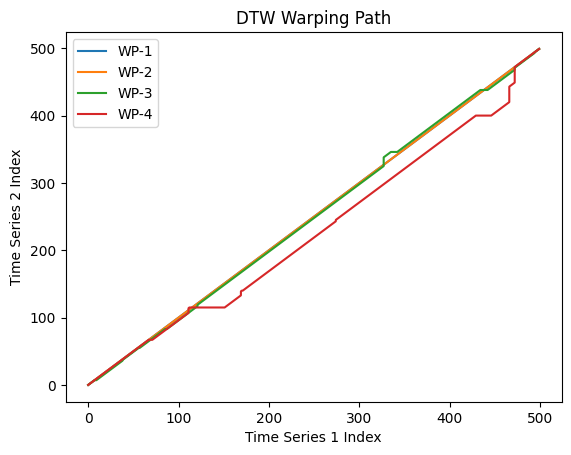

In [130]:
distance1, path1 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 5].reshape(-1, 1), dist=euclidean)
distance2, path2 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 7].reshape(-1, 1), dist=euclidean)
distance3, path3 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 8].reshape(-1, 1), dist=euclidean)
distance4, path4 = fastdtw(new_data[1:, 1].reshape(-1, 1), new_data[1:, 11].reshape(-1, 1), dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()


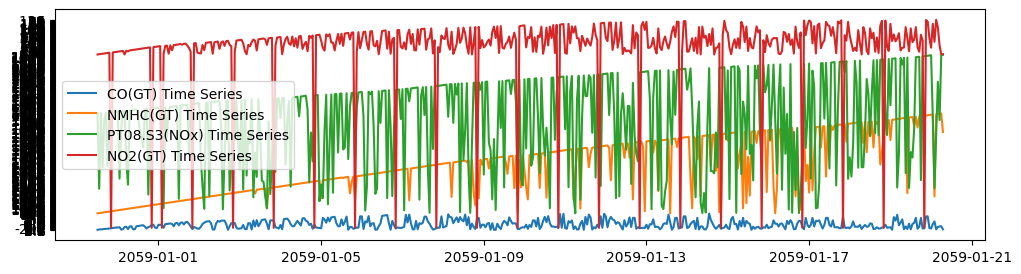

In [105]:

plt.figure(figsize=(12, 3))
plt.plot(ts_1, label='CO(GT) Time Series')
plt.plot(ts_2, label='NMHC(GT) Time Series')
plt.plot(ts_3, label='PT08.S3(NOx) Time Series')
plt.plot(ts_4, label='NO2(GT) Time Series')
plt.legend()

In [15]:
# Decompose time-series
result_add1 = seasonal_decompose(ts_1, model='additive')
result_add2 = seasonal_decompose(ts_2, model='additive')
result_add3 = seasonal_decompose(ts_3, model='additive')
result_add4 = seasonal_decompose(ts_4, model='additive')

result_addn = seasonal_decompose(ts_n, model='additive')


In [16]:
# Get Long trends
result_trend1 = np.array(result_add1.trend)
result_trend2 = np.array(result_add2.trend)
result_trend3 = np.array(result_add3.trend)
result_trend4 = np.array(result_add4.trend)
result_trend5 = np.array(result_addn.trend)

result_trend1 = result_trend1[~np.isnan(result_trend1)]
result_trend2 = result_trend2[~np.isnan(result_trend2)]
result_trend3 = result_trend3[~np.isnan(result_trend3)]
result_trend4 = result_trend4[~np.isnan(result_trend4)]
result_trend5 = result_trend5[~np.isnan(result_trend5)]


# Normalization
scaler = MinMaxScaler()

result_norm1 = scaler.fit_transform(result_trend1.reshape(-1, 1))
result_norm2 = scaler.fit_transform(result_trend2.reshape(-1, 1))
result_norm3 = scaler.fit_transform(result_trend3.reshape(-1, 1))
result_norm4 = scaler.fit_transform(result_trend4.reshape(-1, 1))
result_norm5 = scaler.fit_transform(result_trend5.reshape(-1, 1))


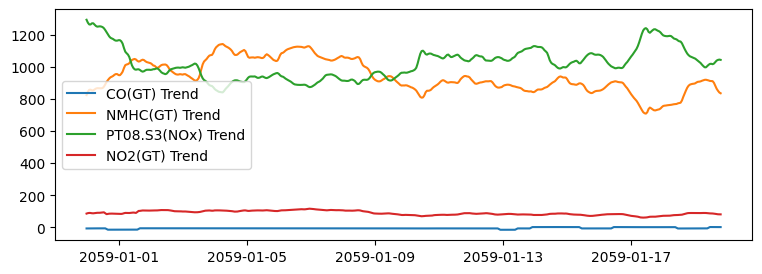

In [108]:
# Plotting 'Trend' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.trend, label='CO(GT) Trend')
plt.plot(result_add2.trend, label='NMHC(GT) Trend')
plt.plot(result_add3.trend, label='PT08.S3(NOx) Trend')
plt.plot(result_add4.trend, label='NO2(GT) Trend')
# plt.plot(result_addn.trend, label='Negative ')
plt.legend()

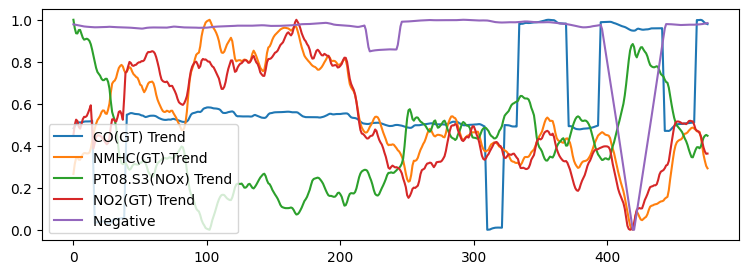

In [112]:
# Plot Normalized Components

plt.figure(figsize=(9, 3))
plt.plot(result_norm1, label='CO(GT) Trend')
plt.plot(result_norm2, label='NMHC(GT) Trend')
plt.plot(result_norm3, label='PT08.S3(NOx) Trend')
plt.plot(result_norm4, label='NO2(GT) Trend')
plt.plot(result_norm5, label='Negative ')
plt.legend()

In [113]:
# Compute Cosine Similarity

sim1 = np.dot(result_norm1.ravel(), result_norm2.ravel())/(norm(result_norm1.ravel())*norm(result_norm2.ravel()))
sim2 = np.dot(result_norm1.ravel(), result_norm3.ravel())/(norm(result_norm1.ravel())*norm(result_norm3.ravel()))
sim3 = np.dot(result_norm1.ravel(), result_norm4.ravel())/(norm(result_norm1.ravel())*norm(result_norm4.ravel()))
sim4 = np.dot(result_norm1.ravel(), result_norm5.ravel())/(norm(result_norm1.ravel())*norm(result_norm5.ravel()))

print(f"Cosine Similarity 1: {sim1}")
print(f"Cosine Similarity 2: {sim2}")
print(f"Cosine Similarity 3: {sim3}")
print(f"Cosine Similarity (N) 4: {sim4}")

Cosine Similarity 1: 0.7999573438397835
Cosine Similarity 2: 0.8300530210070042
Cosine Similarity 3: 0.8036299623918058
Cosine Similarity (N) 4: 0.8758106687870119


In [114]:
sim1 = np.dot(result_trend1.ravel(), result_trend2.ravel())/(norm(result_trend1.ravel())*norm(result_trend2.ravel()))
sim2 = np.dot(result_trend1.ravel(), result_trend3.ravel())/(norm(result_trend1.ravel())*norm(result_trend3.ravel()))
sim3 = np.dot(result_trend1.ravel(), result_trend4.ravel())/(norm(result_trend1.ravel())*norm(result_trend4.ravel()))
sim4 = np.dot(result_trend1.ravel(), result_trend5.ravel())/(norm(result_trend1.ravel())*norm(result_trend5.ravel()))

print(f"Cosine Similarity 1: {sim1}")
print(f"Cosine Similarity 2: {sim2}")
print(f"Cosine Similarity 3: {sim3}")
print(f"Cosine Similarity (N) 4: {sim4}")

Cosine Similarity 1: -0.7964728594493583
Cosine Similarity 2: -0.7716545615947812
Cosine Similarity 3: -0.7945459893033372
Cosine Similarity (N) 4: -0.3262606298420254


DTW distance: 448928.4125000002
DTW distance: 486852.16250000015
DTW distance: 44973.641666666685
DTW distance: 11759.281249999993


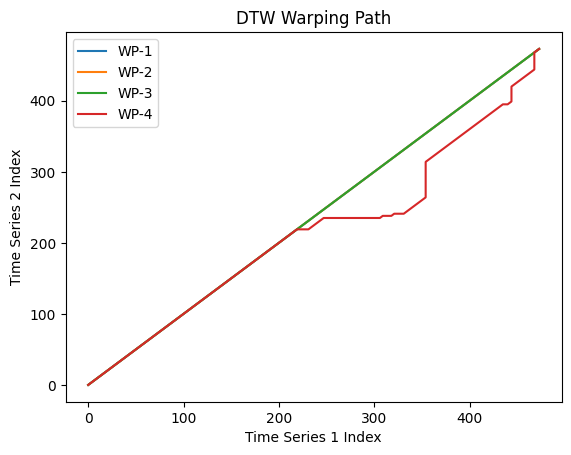

In [17]:
distance1, path1 = fastdtw(result_trend1.reshape(-1, 1), result_trend2.reshape(-1, 1), dist=euclidean)
distance2, path2 = fastdtw(result_trend1.reshape(-1, 1), result_trend3.reshape(-1, 1), dist=euclidean)
distance3, path3 = fastdtw(result_trend1.reshape(-1, 1), result_trend4.reshape(-1, 1), dist=euclidean)
distance4, path4 = fastdtw(result_trend1.reshape(-1, 1), result_trend5.reshape(-1, 1), dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()


In [20]:
arr_path = np.array(path1)
err = np.abs(arr_path[:, 0] - arr_path[:, 1])
avg_err = np.mean(err)
avg_err

np.float64(0.0)

DTW distance: 129.72805428680346
DTW distance: 65.05307830254654
DTW distance: 119.61783439054231
DTW distance: 172.35645119127065


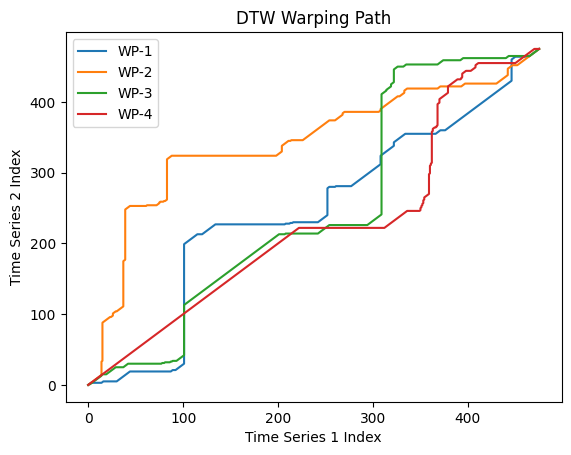

In [132]:
distance1, path1 = fastdtw(result_norm1, result_norm2, dist=euclidean)
distance2, path2 = fastdtw(result_norm1, result_norm3, dist=euclidean)
distance3, path3 = fastdtw(result_norm1, result_norm4, dist=euclidean)
distance4, path4 = fastdtw(result_norm1, result_norm5, dist=euclidean)

print(f"DTW distance: {distance1}")
print(f"DTW distance: {distance2}")
print(f"DTW distance: {distance3}")
print(f"DTW distance: {distance4}")

plt.plot([p[0] for p in path1], [p[1] for p in path1], '-', label="WP-1")
plt.plot([p[0] for p in path2], [p[1] for p in path2], '-', label="WP-2")
plt.plot([p[0] for p in path3], [p[1] for p in path3], '-', label="WP-3")
plt.plot([p[0] for p in path4], [p[1] for p in path4], '-', label="WP-4")

plt.xlabel('Time Series 1 Index')
plt.ylabel('Time Series 2 Index')
plt.title('DTW Warping Path')
plt.legend()
plt.show()

In [87]:

# define two lists or array
A = np.array([2,1,2,3,2,9])
B = np.array([33,42,21,43,54,50])  # similar
# B = np.array([98, 65, 4, 12, 3, 6])  # different

scaler1 = MinMaxScaler()
scaler2 = StandardScaler()

A_norm1 = scaler1.fit_transform(A.reshape(-1, 1))
A_norm2 = scaler2.fit_transform(A.reshape(-1, 1))
A_norm1 = A_norm1.ravel()
A_norm2 = A_norm2.ravel()

B_norm1 = scaler1.fit_transform(B.reshape(-1, 1))
B_norm2 = scaler2.fit_transform(B.reshape(-1, 1))
B_norm1 = B_norm1.ravel()
B_norm2 = B_norm2.ravel()
 
# compute cosine similarity
sim1 = np.dot(A,B)/(norm(A)*norm(B))
sim2 = np.dot(A_norm1,B_norm1)/(norm(A_norm1)*norm(B_norm1))
sim3 = np.dot(A_norm2,B_norm2)/(norm(A_norm2)*norm(B_norm2))

print("Cosine Similarity (Original):", sim1)
print("Cosine Similarity (MinMax):", sim2)
print("Cosine Similarity (ZScore):", sim3)

Cosine Similarity (Original): 0.8025931535467922
Cosine Similarity (MinMax): 0.6956449314632467
Cosine Similarity (ZScore): 0.38503648468374496


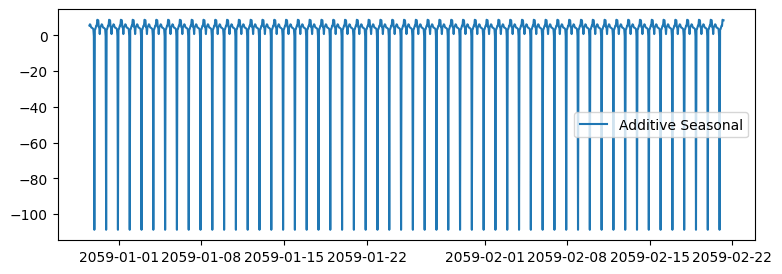

In [35]:
# Plotting 'Seasonal' Component

plt.figure(figsize=(9, 3))
plt.plot(result_add1.seasonal, label='Additive Seasonal')
plt.legend()

In [1]:
# Calculating the Simple Moving Average (SMA)
   
sma_window = 8  # 8-hour moving average
sma1 = ts_1.rolling(window=sma_window).mean()
sma2 = ts_2.rolling(window=sma_window).mean()
sma3 = ts_3.rolling(window=sma_window).mean()
sma4 = ts_4.rolling(window=sma_window).mean()
#sma1

NameError: name 'ts_1' is not defined

In [2]:
# Calculating the Exponential Moving Average (EMA)

ema_window = 24  # 24-hour moving average
ema1 = ts_1.ewm(span=ema_window, adjust=False).mean()
ema2 = ts_2.ewm(span=ema_window, adjust=False).mean()
ema3 = ts_3.ewm(span=ema_window, adjust=False).mean()
ema4 = ts_4.ewm(span=ema_window, adjust=False).mean()
#ema1


NameError: name 'ts_1' is not defined

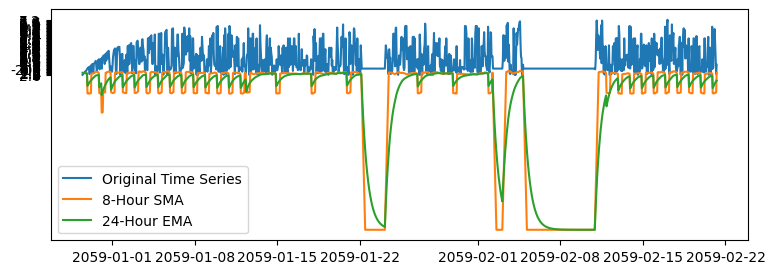

In [66]:
# Plotting the Moving Averages

plt.figure(figsize=(9, 3))
plt.plot(ts_1, label='Original Time Series')
plt.plot(sma1, label=f'{sma_window}-Hour SMA')
plt.plot(ema1, label=f'{ema_window}-Hour EMA')
plt.legend()